# Chapter 8 – Dimensionality Reduction


First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20.

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "1.0.2"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "dim_reduction"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

## The Curse of Dimensionality

Here is a more troublesome difference: if you pick two points randomly in a unit square, the distance between these two points will be, on average, roughly 0.52. If you pick two random points in a unit 3D cube, the average distance will be roughly 0.66. But what about two points picked randomly in a 1,000,000-dimensional hypercube? The average distance, believe it or not, will be about 408.25 (roughly $\sqrt{1,000,000/6}$)! This is counterintuitive: how can two points be so far apart when they both lie within the same unit hypercube? Well, there’s just plenty of space in high dimensions. As a result, high-dimensional datasets are at risk of being very sparse: most training instances are likely to be far away from each other. This also means that a new instance will likely be far away from any training instance, making predictions much less reliable than in lower dimensions, since they will be based on much larger extrapolations. In short, the more dimensions the training set has, the greater the risk of overfitting it.

Let 2 points $(x_1,y_1), (x_2,y_2)$, and $(x_i,y_i)$ for $i=1,2$ be i.i.d. and has uniform distribution on $[0,1]^2$. Then the distance of these two independent random variables with standard uniform distribution in the $x$ axis is $x=|x_1−x_2|$, which follows [triangular distribution](https://www.wikiwand.com/en/Triangular_distribution#/Distribution_of_the_absolute_difference_of_two_standard_uniform_variables) (where a = 0, b = 1 and c = 0), which has PDF (https://math.stackexchange.com/questions/1681363/cdf-of-absolute-value-of-difference-in-random-variables):

$$f(x)=\begin{cases}
2(1−x), & 0\le x\le 1 \\
0, & \text{otherwise} \\
\end{cases}$$
and the distance in the $y$ axis is $y=|y_1−y_2|$ with PDF $$f(y)=\begin{cases}
2(1−y), & 0\le y\le 1 \\
0, & \text{otherwise} \\
\end{cases}$$

The distance in 2D is $$\sqrt{x^2+y^2}$$ and the probability is 
$$\begin{align}
4\int_{0}^{1}\int_{0}^{1}\sqrt{x^2+y^2}(1−x)(1−y)dxdy &= 4\int_{0}^{\pi/2}\int_{0}^{1/\cos\theta}r(1-r \cos \theta)(1-r\sin\theta)rdrd\theta\\
&=8\int_{0}^{\pi/4}\int_{0}^{1/\cos\theta}r(1-r \cos \theta)(1-r\sin\theta)rdrd\theta\\
&=8\int_{0}^{\pi/4}\int_{0}^{1/\cos\theta}r^2(1-r \cos \theta)(1-r\sin\theta)drd\theta\\
&=8\int_{0}^{\pi/4}\int_{0}^{1/\cos\theta}r^2(1-r \cos \theta-r\sin\theta+r^2\cos \theta\sin\theta)drd\theta\\
&=8\int_{0}^{\pi/4}\int_{0}^{1/\cos\theta}r^2-r^3 \cos \theta-r^3\sin\theta+r^4\cos \theta\sin\theta drd\theta\\
&=8\int_{0}^{\pi/4}\left\{\frac{r^3}{3}\big|_{0}^{1/\cos\theta}-\frac{r^4}{4}\cos\theta\big|_{0}^{1/\cos\theta}-\frac{r^4}{4}\sin\theta\big|_{0}^{1/\cos\theta}+\frac{r^5}{5}\cos\theta\sin\theta\big|_{0}^{1/\cos\theta} \right\}d\theta\\
&=8\int_{0}^{\pi/4}\left\{\frac{\sec^3\theta}{3}-\frac{\sec^4\theta}{4}\cos\theta-\frac{\sec^4\theta}{4}\sin\theta+\frac{\sec^5\theta}{5}\cos\theta\sin\theta \right\}d\theta\\
&=8\int_{0}^{\pi/4}\left\{\frac{\sec^3\theta}{3}-\frac{\sec^3\theta}{4}-\frac{\sec^3\theta}{4}\tan\theta+\frac{\sec^3\theta}{5}\tan\theta \right\}d\theta\\
&=8\int_{0}^{\pi/4}\left\{\frac{\sec^3\theta}{12}-\frac{\sec^3\theta}{20}\tan\theta\right\}d\theta\\
&=8\left[\int_{0}^{\pi/4}\frac{\sec^3\theta}{12}d\theta-\frac{\sec^3\theta}{60}\big|_{0}^{\pi/4}\right]\\
&=8\left[\frac{\sec\theta\tan\theta+\ln|\sec\theta+\tan\theta|}{24}\big|_{0}^{\pi/4}-\frac{\sec^3\theta}{60}\big|_{0}^{\pi/4}\right]\\
&=8\left[\frac{\sec\theta\tan\theta+\ln|\sec\theta+\tan\theta|}{24}\big|_{0}^{\pi/4}-\frac{2\sqrt{2}}{60}+\frac{1}{60}\right]\\
&=8\left[\frac{\sqrt{2}+\ln|\sqrt{2}+1|}{24}-\frac{2\sqrt{2}}{60}+\frac{1}{60}\right]\\
&=\frac{\sqrt{2}+\ln|\sqrt{2}+1|}{3}-\frac{4\sqrt{2}}{15}+\frac{2}{15}\\
&=\frac{5\sqrt{2}+5\ln|\sqrt{2}+1|-4\sqrt{2}+2}{15}\\
&=\frac{2+\sqrt{2}+5\ln|\sqrt{2}+1|}{15}\\
&\approx 0.5214
\end{align}$$

Ref: [integral of the secant cubed](https://www.wikiwand.com/en/Integral_of_secant_cubed)
and 
$$\begin{align}
\int_{0}^{\pi/4}\left(\frac{\sec^3\theta}{20}\tan\theta\right) d\theta &= \int_{0}^{\pi/4}\left(\frac{\sec^4\theta}{20}\sin\theta\right) d\theta\\
&=-\frac{\sec^4\theta}{20}\cos\theta\big|_{0}^{\pi/4}+\int_{0}^{\pi/4}\frac{\sec^3\theta}{5}\cos\theta d(\sec\theta)\\
&=-\frac{\sec^4\theta}{20}\cos\theta\big|_{0}^{\pi/4}+\int_{0}^{\pi/4}\frac{\sec^3\theta}{5}\cos\theta \sec^2\theta\sin\theta d\theta\\
&=-\frac{\sec^4\theta}{20}\cos\theta\big|_{0}^{\pi/4}+\int_{0}^{\pi/4}\frac{\sec^4\theta}{5} \sin\theta d\theta\\
&=-\frac{\sec^3\theta}{20}\big|_{0}^{\pi/4}+\int_{0}^{\pi/4}\frac{\sec^4\theta}{5} \sin\theta d\theta\\
&\Rightarrow \int_{0}^{\pi/4}\sec^4\theta \sin\theta d\theta = \frac{\sec^3\theta}{3}\big|_{0}^{\pi/4}
\end{align}$$

In 3D the probability of the distance inside a unit cube is [Cube Line Picking](https://mathworld.wolfram.com/CubeLinePicking.html)
$$2^3\int_{0}^{1}\int_{0}^{1}\int_{0}^{1}\sqrt{x^2+y^2+z^2}(1−x)(1−y)(1-z)dxdydz\approx 0.6617$$
Since $$\mathbb E(x^2)=\mathbb E(y^2)=\mathbb E(z^2)=2\int_{0}^{1}x^2(1-x)dx=\frac{1}{6}$$ then $$2^3\int_{0}^{1}\int_{0}^{1}\int_{0}^{1}\sqrt{x^2+y^2+z^2}(1−x)(1−y)(1-z)dxdydz\le \sqrt{\frac{1}{6}+\frac{1}{6}+\frac{1}{6}}=\sqrt{\frac{1}{2}}=\frac{\sqrt{2}}{2}$$

## Main Approaches for Dimensionality Reduction

### PCA using Scikit-Learn

With Scikit-Learn, PCA is really trivial. It even takes care of mean centering for you:

In [2]:
np.random.seed(4)
m = 60
w1, w2 = 0.1, 0.3
noise = 0.1

angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
X = np.empty((m, 3))
X[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
X[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
X[:, 2] = X[:, 0] * w1 + X[:, 1] * w2 + noise * np.random.randn(m)

In [3]:
X[:5]

array([[-1.01570027, -0.55091331, -0.26132626],
       [-0.00771675,  0.59958572,  0.03507755],
       [-0.95317135, -0.46453691, -0.24920288],
       [-0.92012304,  0.21009593,  0.02182381],
       [-0.76309739,  0.158261  ,  0.19152496]])

In [4]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 2)
X2D = pca.fit_transform(X)

In [5]:
X2D[:5]

array([[ 1.26203346,  0.42067648],
       [-0.08001485, -0.35272239],
       [ 1.17545763,  0.36085729],
       [ 0.89305601, -0.30862856],
       [ 0.73016287, -0.25404049]])

Recover the 3D points projected on the plane (PCA 2D subspace).

In [6]:
X3D_inv = pca.inverse_transform(X2D)

In [7]:
X3D_inv[:5]

array([[-1.01450604, -0.54656333, -0.27441525],
       [-0.02103231,  0.55108376,  0.18101894],
       [-0.95379477, -0.4668077 , -0.24237013],
       [-0.91717404,  0.22083765, -0.01049779],
       [-0.74607229,  0.22027492,  0.00492637]])

In [8]:
pca.components_.shape

(2, 3)

In [9]:
axes = [-1.8, 1.8, -1.3, 1.3, -1.0, 1.0]

x1s = np.linspace(axes[0], axes[1], 10)
x2s = np.linspace(axes[2], axes[3], 10)
x1, x2 = np.meshgrid(x1s, x2s)

C = pca.components_
R = C.T.dot(C)
z = (R[0, 2] * x1 + R[1, 2] * x2) / (1 - R[2, 2]) # z is for plot the surface

In [10]:
R.shape, C.T.dot(C).shape

((3, 3), (3, 3))

In [11]:
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d

class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        FancyArrowPatch.draw(self, renderer)

<ipython-input-12-d378521920eb>:21: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  ax.plot([X[i][0], X3D_inv[i][0]], [X[i][1], X3D_inv[i][1]], [X[i][2], X3D_inv[i][2]], "k-", color="#505050")


Saving figure dataset_3d_plot


<ipython-input-11-dbc6177a42f4>:11: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)


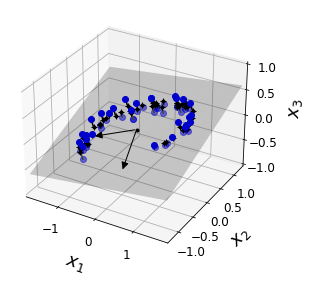

In [12]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(6, 3.8))
ax = fig.add_subplot(111, projection='3d')

X3D_above = X[X[:, 2] > X3D_inv[:, 2]]
X3D_below = X[X[:, 2] <= X3D_inv[:, 2]]

ax.plot(X3D_below[:, 0], X3D_below[:, 1], X3D_below[:, 2], "bo", alpha=0.5)

ax.plot_surface(x1, x2, z, alpha=0.2, color="k")
np.linalg.norm(C, axis=0)
ax.add_artist(Arrow3D([0, C[0, 0]],[0, C[0, 1]],[0, C[0, 2]], mutation_scale=15, lw=1, arrowstyle="-|>", color="k"))
ax.add_artist(Arrow3D([0, C[1, 0]],[0, C[1, 1]],[0, C[1, 2]], mutation_scale=15, lw=1, arrowstyle="-|>", color="k"))
ax.plot([0], [0], [0], "k.")

for i in range(m):
    if X[i, 2] > X3D_inv[i, 2]:
        ax.plot([X[i][0], X3D_inv[i][0]], [X[i][1], X3D_inv[i][1]], [X[i][2], X3D_inv[i][2]], "k-")
    else:
        ax.plot([X[i][0], X3D_inv[i][0]], [X[i][1], X3D_inv[i][1]], [X[i][2], X3D_inv[i][2]], "k-", color="#505050")
    
ax.plot(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2], "k+")
ax.plot(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2], "k.")
ax.plot(X3D_above[:, 0], X3D_above[:, 1], X3D_above[:, 2], "bo")
ax.set_xlabel("$x_1$", fontsize=18, labelpad=10)
ax.set_ylabel("$x_2$", fontsize=18, labelpad=10)
ax.set_zlabel("$x_3$", fontsize=18, labelpad=10)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

# Note: If you are using Matplotlib 3.0.0, it has a bug and does not
# display 3D graphs properly.
# See https://github.com/matplotlib/matplotlib/issues/12239
# You should upgrade to a later version. If you cannot, then you can
# use the following workaround before displaying each 3D graph:
# for spine in ax.spines.values():
#     spine.set_visible(False)

save_fig("dataset_3d_plot")
plt.show()

Figure 8-2. A 3D dataset lying close to a 2D subspace

Saving figure dataset_2d_plot


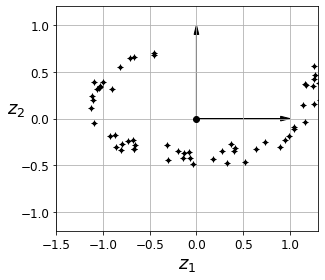

In [13]:
fig = plt.figure()
ax = fig.add_subplot(111, aspect='equal')

ax.plot(X2D[:, 0], X2D[:, 1], "k+")
ax.plot(X2D[:, 0], X2D[:, 1], "k.")
ax.plot([0], [0], "ko")
ax.arrow(0, 0, 0, 1, head_width=0.05, length_includes_head=True, head_length=0.1, fc='k', ec='k')
ax.arrow(0, 0, 1, 0, head_width=0.05, length_includes_head=True, head_length=0.1, fc='k', ec='k')
ax.set_xlabel("$z_1$", fontsize=18)
ax.set_ylabel("$z_2$", fontsize=18, rotation=0)
ax.axis([-1.5, 1.3, -1.2, 1.2])
ax.grid(True)
save_fig("dataset_2d_plot")

Figure 8-3. The new 2D dataset after projection

However, projection is not always the best approach to dimensionality reduction. In many cases the subspace may twist and turn, such as in the famous Swiss roll toy dataset represented in Figure 8-4.

### Manifold learning 

Swiss roll:

In [14]:
from sklearn.datasets import make_swiss_roll
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)
X.shape, t.shape, X[0], t[0]

((1000, 3),
 (1000,),
 array([-3.29677117,  4.26198454,  7.69787682]),
 8.242346437921256)

Saving figure swiss_roll_plot


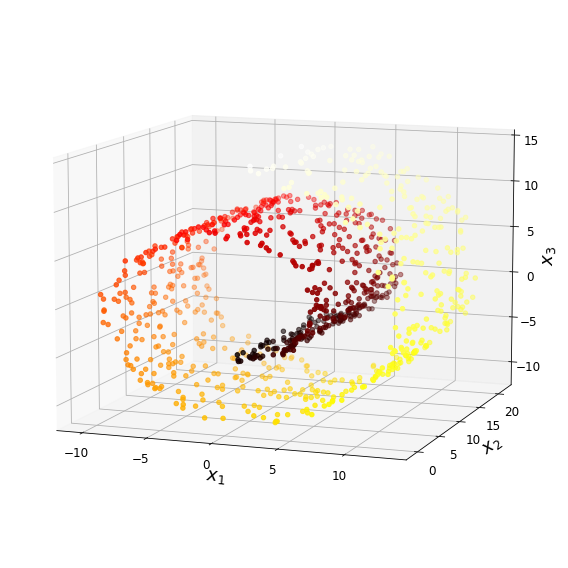

In [15]:
axes = [-11.5, 14, -2, 23, -12, 15]

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=t, cmap=plt.cm.hot)
ax.view_init(10, -70)
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

save_fig("swiss_roll_plot")
plt.show()

Figure 8-4. Swiss roll dataset

Simply projecting onto a plane (e.g., by dropping $x_3$) would squash different layers of the Swiss roll together, as shown on the left side of Figure 8-5. What you really want is to unroll the Swiss roll to obtain the 2D dataset on the right side of Figure 8-5.

Saving figure squished_swiss_roll_plot


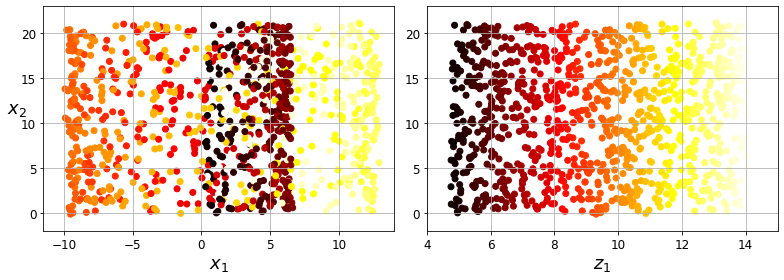

In [16]:
plt.figure(figsize=(11, 4))

plt.subplot(121)
plt.scatter(X[:, 0], X[:, 1], c=t, cmap=plt.cm.hot)
plt.axis(axes[:4])
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$x_2$", fontsize=18, rotation=0)
plt.grid(True)

plt.subplot(122)
plt.scatter(t, X[:, 1], c=t, cmap=plt.cm.hot)
plt.axis([4, 15, axes[2], axes[3]])
plt.xlabel("$z_1$", fontsize=18)
plt.grid(True)

save_fig("squished_swiss_roll_plot")
plt.show()

Figure 8-5. Squashing by projecting onto a plane (left) versus unrolling the Swiss roll (right)

The Swiss roll is an example of a 2D *manifold*. Put simply, a 2D manifold is a 2D shape that can be bent and twisted in a higher-dimensional space. More generally, a d-dimensional manifold is a part of an n-dimensional space (where d < n) that locally resembles a d-dimensional hyperplane. In the case of the Swiss roll, d = 2 and n = 3: it locally resembles a 2D plane, but it is rolled in the third dimension.

Many dimensionality reduction algorithms work by modeling the manifold on which the training instances lie; this is called *Manifold Learning*. It relies on the manifold assumption, also called the *manifold hypothesis*, which holds that most real-world high-dimensional datasets lie close to a much lower-dimensional manifold. This assumption is very often empirically observed.

Saving figure manifold_decision_boundary_plot1


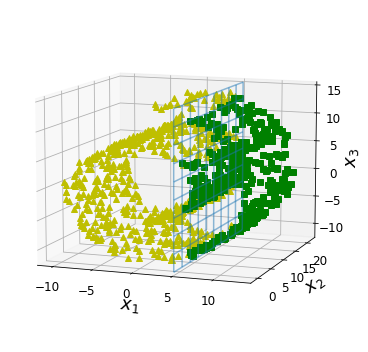

Saving figure manifold_decision_boundary_plot2


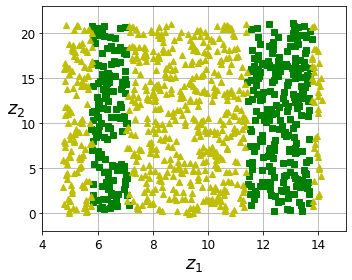

Saving figure manifold_decision_boundary_plot3


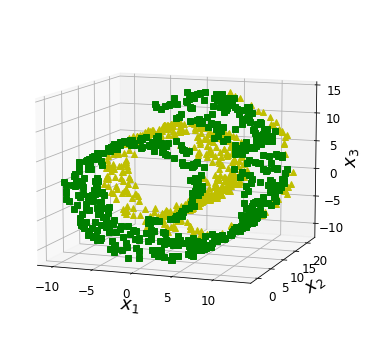

Saving figure manifold_decision_boundary_plot4


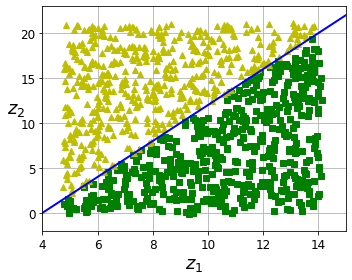

In [17]:
from matplotlib import gridspec

axes = [-11.5, 14, -2, 23, -12, 15]

x2s = np.linspace(axes[2], axes[3], 10)
x3s = np.linspace(axes[4], axes[5], 10)
x2, x3 = np.meshgrid(x2s, x3s)

fig = plt.figure(figsize=(6, 5))
ax = plt.subplot(111, projection='3d')

positive_class = X[:, 0] > 5
X_pos = X[positive_class]
X_neg = X[~positive_class]
ax.view_init(10, -70)
ax.plot(X_neg[:, 0], X_neg[:, 1], X_neg[:, 2], "y^")
ax.plot_wireframe(5, x2, x3, alpha=0.5)
ax.plot(X_pos[:, 0], X_pos[:, 1], X_pos[:, 2], "gs")
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

save_fig("manifold_decision_boundary_plot1")
plt.show()

fig = plt.figure(figsize=(5, 4))
ax = plt.subplot(111)

plt.plot(t[positive_class], X[positive_class, 1], "gs")
plt.plot(t[~positive_class], X[~positive_class, 1], "y^")
plt.axis([4, 15, axes[2], axes[3]])
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)

save_fig("manifold_decision_boundary_plot2")
plt.show()

fig = plt.figure(figsize=(6, 5))
ax = plt.subplot(111, projection='3d')

positive_class = 2 * (t[:] - 4) > X[:, 1]
X_pos = X[positive_class]
X_neg = X[~positive_class]
ax.view_init(10, -70)
ax.plot(X_neg[:, 0], X_neg[:, 1], X_neg[:, 2], "y^")
ax.plot(X_pos[:, 0], X_pos[:, 1], X_pos[:, 2], "gs")
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

save_fig("manifold_decision_boundary_plot3")
plt.show()

fig = plt.figure(figsize=(5, 4))
ax = plt.subplot(111)

plt.plot(t[positive_class], X[positive_class, 1], "gs")
plt.plot(t[~positive_class], X[~positive_class, 1], "y^")
plt.plot([4, 15], [0, 22], "b-", linewidth=2)
plt.axis([4, 15, axes[2], axes[3]])
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)

save_fig("manifold_decision_boundary_plot4")
plt.show()

Figure 8-6. The decision boundary may not always be simpler with lower dimensions

### PCA

*Principal Component Analysis (PCA)* is by far the most popular dimensionality reduction algorithm. First it identifies the hyperplane that lies closest to the data, and then it projects the data onto it, just like in Figure 8-2.

**Preserving the Variance**

Saving figure pca_best_projection_plot


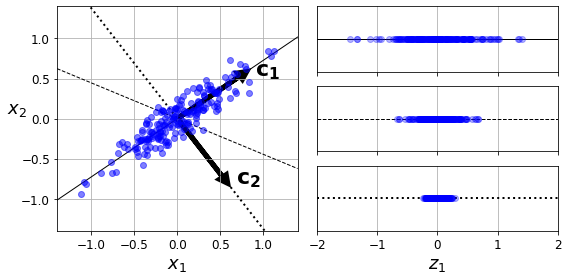

In [18]:
angle = np.pi / 5
stretch = 5
m = 200

np.random.seed(3)
X = np.random.randn(m, 2) / 10
X = X.dot(np.array([[stretch, 0],[0, 1]])) # stretch
X = X.dot([[np.cos(angle), np.sin(angle)], [-np.sin(angle), np.cos(angle)]]) # rotate

u1 = np.array([np.cos(angle), np.sin(angle)])
u2 = np.array([np.cos(angle - 2 * np.pi/6), np.sin(angle - 2 * np.pi/6)])
u3 = np.array([np.cos(angle - np.pi/2), np.sin(angle - np.pi/2)])

X_proj1 = X.dot(u1.reshape(-1, 1))
X_proj2 = X.dot(u2.reshape(-1, 1))
X_proj3 = X.dot(u3.reshape(-1, 1))

plt.figure(figsize=(8,4))
plt.subplot2grid((3,2), (0, 0), rowspan=3)
plt.plot([-1.4, 1.4], [-1.4*u1[1]/u1[0], 1.4*u1[1]/u1[0]], "k-", linewidth=1)
plt.plot([-1.4, 1.4], [-1.4*u2[1]/u2[0], 1.4*u2[1]/u2[0]], "k--", linewidth=1)
plt.plot([-1.4, 1.4], [-1.4*u3[1]/u3[0], 1.4*u3[1]/u3[0]], "k:", linewidth=2)
plt.plot(X[:, 0], X[:, 1], "bo", alpha=0.5)
plt.axis([-1.4, 1.4, -1.4, 1.4])
plt.arrow(0, 0, u1[0], u1[1], head_width=0.1, linewidth=5, length_includes_head=True, head_length=0.1, fc='k', ec='k')
plt.arrow(0, 0, u3[0], u3[1], head_width=0.1, linewidth=5, length_includes_head=True, head_length=0.1, fc='k', ec='k')
plt.text(u1[0] + 0.1, u1[1] - 0.05, r"$\mathbf{c_1}$", fontsize=22)
plt.text(u3[0] + 0.1, u3[1], r"$\mathbf{c_2}$", fontsize=22)
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$x_2$", fontsize=18, rotation=0)
plt.grid(True)

plt.subplot2grid((3,2), (0, 1))
plt.plot([-2, 2], [0, 0], "k-", linewidth=1)
plt.plot(X_proj1[:, 0], np.zeros(m), "bo", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.gca().get_xaxis().set_ticklabels([])
plt.axis([-2, 2, -1, 1])
plt.grid(True)

plt.subplot2grid((3,2), (1, 1))
plt.plot([-2, 2], [0, 0], "k--", linewidth=1)
plt.plot(X_proj2[:, 0], np.zeros(m), "bo", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.gca().get_xaxis().set_ticklabels([])
plt.axis([-2, 2, -1, 1])
plt.grid(True)

plt.subplot2grid((3,2), (2, 1))
plt.plot([-2, 2], [0, 0], "k:", linewidth=2)
plt.plot(X_proj3[:, 0], np.zeros(m), "bo", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.axis([-2, 2, -1, 1])
plt.xlabel("$z_1$", fontsize=18)
plt.grid(True)

save_fig("pca_best_projection_plot")
plt.show()

Figure 8-7. Selecting the subspace to project on

The following Python code uses NumPy’s `svd()` function to obtain all the principal components of the training set, then extracts the two unit vectors that define the first two PCs:

>WARNING  
>PCA assumes that the dataset is centered around the origin. As we will see, Scikit-Learn’s PCA classes take care of centering the data for you. If you implement PCA yourself (as in the preceding example), or if you use other libraries, don’t forget to center the data first.

In [19]:
np.random.seed(4)
m = 60
w1, w2 = 0.1, 0.3
noise = 0.1

angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
X = np.empty((m, 3))
X[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
X[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
X[:, 2] = X[:, 0] * w1 + X[:, 1] * w2 + noise * np.random.randn(m)

In [20]:
X_centered = X - X.mean(axis=0)
U, s, Vt = np.linalg.svd(X_centered)

c1 = Vt.T[:, 0]
c2 = Vt.T[:, 1]

**Projecting Down to d Dimensions**  


Once you have identified all the principal components, you can reduce the dimensionality of the dataset down to d dimensions by projecting it onto the hyperplane defined by the first d principal components. Selecting this hyperplane ensures that the projection will preserve as much variance as possible. For example, in Figure 8-2 the 3D dataset is projected down to the 2D plane defined by the first two principal components, preserving a large part of the dataset’s variance. As a result, the 2D projection looks very much like the original 3D dataset.

To project the training set onto the hyperplane and obtain a reduced dataset $\mathbf X_{d-proj}$ of dimensionality d, compute the matrix multiplication of the training set matrix $\mathbf X$ by the matrix $\mathbf W_d$, defined as the matrix containing the first d columns of $\mathbf V$, as shown in Equation 8-2.

*Equation 8-2. Projecting the training set down to d dimensions*

$$\mathbf X_{d-proj}=\mathbf X\mathbf W_d$$

The following Python code projects the training set onto the plane defined by the first two principal components:

In [21]:
W2 = Vt.T[:, :2]
X2D = X_centered.dot(W2)

**Using Scikit-Learn**  


Scikit-Learn’s `PCA` class uses SVD decomposition to implement PCA, just like we did earlier in this chapter. The following code applies PCA to reduce the dimensionality of the dataset down to two dimensions (note that it automatically takes care of centering the data):

In [22]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 2)
X2D = pca.fit_transform(X)

After fitting the PCA transformer to the dataset, its `components_` attribute holds the transpose of $\mathbf W_d$ (e.g., the unit vector that defines the first principal component is equal to `pca.components_.T[:, 0]`).

**Explained Variance Ratio**  

Now let's look at the explained variance ratio:

In [23]:
pca.explained_variance_ratio_

array([0.84248607, 0.14631839])

The first dimension explains 84.25% of the variance, while the second explains 14.63%.

By projecting down to 2D, we lost about 1.1% of the variance:

In [24]:
1 - pca.explained_variance_ratio_.sum()

0.011195535570688975

Here is how to compute the explained variance ratio using the SVD approach (recall that `s` is the diagonal of the matrix `S`):

In [25]:
np.square(s) / np.square(s).sum()

array([0.84248607, 0.14631839, 0.01119554])

**Choosing the Right Number of Dimensions**

Instead of arbitrarily choosing the number of dimensions to reduce down to, it is simpler to choose the number of dimensions that add up to a sufficiently large portion of the variance (e.g., 95%). Unless, of course, you are reducing dimensionality for data visualization—in that case you will want to reduce the dimensionality down to 2 or 3.

The following code performs PCA without reducing dimensionality, then computes the minimum number of dimensions required to preserve 95% of the training set’s variance:

In [26]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)
mnist.target = mnist.target.astype(np.uint8)

In [27]:
from sklearn.model_selection import train_test_split

X = mnist["data"]
y = mnist["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [28]:
pca = PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1

In [29]:
d

154

Saving figure explained_variance_plot


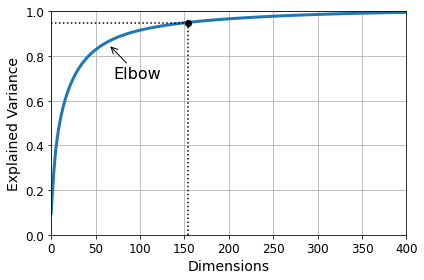

In [30]:
plt.figure(figsize=(6,4))
plt.plot(cumsum, linewidth=3)
plt.axis([0, 400, 0, 1])
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")
plt.plot([d, d], [0, 0.95], "k:")
plt.plot([0, d], [0.95, 0.95], "k:")
plt.plot(d, 0.95, "ko")
plt.annotate("Elbow", xy=(65, 0.85), xytext=(70, 0.7),
             arrowprops=dict(arrowstyle="->"), fontsize=16)
plt.grid(True)
save_fig("explained_variance_plot")
plt.show()

Figure 8-8. Explained variance as a function of the number of dimensions

**PCA for compression**

After dimensionality reduction, the training set takes up much less space. As an example, try applying PCA to the MNIST dataset while preserving 95% of its variance. You should find that each instance will have just over 150 features, instead of the original 784 features. So, while most of the variance is preserved, the dataset is now less than 20% of its original size! This is a reasonable compression ratio, and you can see how this size reduction can speed up a classification algorithm (such as an SVM classifier) tremendously.

It is also possible to decompress the reduced dataset back to 784 dimensions by applying the inverse transformation of the PCA projection. This won’t give you back the original data, since the projection lost a bit of information (within the 5% variance that was dropped), but it will likely be close to the original data. The mean squared distance between the original data and the reconstructed data (compressed and then decompressed) is called the *reconstruction error*.

The following code compresses the MNIST dataset down to 154 dimensions, then uses the `inverse_transform()` method to decompress it back to 784 dimensions:

In [31]:
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X_train)

In [32]:
pca.n_components_

154

In [33]:
np.sum(pca.explained_variance_ratio_)

0.9503684424557421

In [34]:
pca = PCA(n_components = 154)
X_reduced = pca.fit_transform(X_train)
X_recovered = pca.inverse_transform(X_reduced)

In [35]:
X_recovered.shape

(52500, 784)

In [38]:
# each row is a number image, 28*28 pixels, total are 52500 images
X_train.shape

(52500, 784)

In [57]:
def plot_digits(instances, images_per_row=5, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

In [58]:
52500/2100

25.0

In [59]:
len(X_train[::2100]), len(X_train[::1]), len(X_train[::10])

(25, 52500, 5250)

In [69]:
X_recovered[::2100]

array([[ 5.39285778e-14, -1.29240477e-13, -1.18546114e-13, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 3.02032196e-13, -1.03387110e-13, -6.47097579e-14, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 2.47710020e-14, -8.49912806e-14, -9.80674704e-14, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [ 1.51287530e-13,  1.20654053e-14, -6.96821032e-14, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 2.70135202e-13,  3.28582798e-14,  1.04849456e-13, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-6.11257440e-13,  2.88104886e-13, -1.47424600e-14, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])

Saving figure mnist_compression_plot


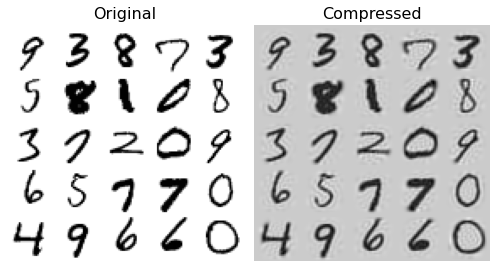

In [70]:
plt.figure(figsize=(7, 4))
plt.subplot(121)
plot_digits(X_train[::2100].values)
plt.title("Original", fontsize=16)
plt.subplot(122)
plot_digits(X_recovered[::2100])
plt.title("Compressed", fontsize=16)

save_fig("mnist_compression_plot")

Figure 8-9. MNIST compression that preserves 95% of the variance

The equation of the inverse transformation is shown in Equation 8-3.

*Equation 8-3. PCA inverse transformation, back to the original number of dimensions*
$$\mathbf X_{recovered}=\mathbf X_{d-proj}\mathbf W_d^T$$

**Randomized PCA**  

If you set the svd_solver hyperparameter to `"randomized"`, Scikit-Learn uses a stochastic algorithm called Randomized PCA that quickly finds an approximation of the first d principal components. Its computational complexity is $O(m \times d^2) + O(d^3)$, instead of $O(m \times n^2) + O(n^3)$ for the full SVD approach, so it is dramatically faster than full SVD when d is much smaller than n:

In [71]:
rnd_pca = PCA(n_components=154, svd_solver="randomized")
X_reduced = rnd_pca.fit_transform(X_train)

By default, svd_solver is actually set to `"auto"`: Scikit-Learn automatically uses the randomized PCA algorithm if m or n is greater than 500 and d is less than 80% of m or n, or else it uses the full SVD approach. If you want to force Scikit-Learn to use full SVD, you can set the svd_solver hyperparameter to `"full"`.

**Incremental PCA**

One problem with the preceding implementations of PCA is that they require the whole training set to fit in memory in order for the algorithm to run. Fortunately, *Incremental PCA (IPCA)* algorithms have been developed. They allow you to split the training set into mini-batches and feed an IPCA algorithm one mini-batch at a time. This is useful for large training sets and for applying PCA online (i.e., on the fly, as new instances arrive).

The following code splits the MNIST dataset into 100 mini-batches (using NumPy’s `array_split()` function) and feeds them to Scikit-Learn’s `IncrementalPCA` class to reduce the dimensionality of the MNIST dataset down to 154 dimensions (just like before). Note that you must call the `partial_fit()` method with each mini-batch, rather than the `fit()` method with the whole training set:

In [72]:
from sklearn.decomposition import IncrementalPCA

n_batches = 100
inc_pca = IncrementalPCA(n_components=154)
for X_batch in np.array_split(X_train, n_batches):
    print(">", end="")
    inc_pca.partial_fit(X_batch)

X_reduced = inc_pca.transform(X_train)

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>

In [73]:
X_recovered_inc_pca = inc_pca.inverse_transform(X_reduced)

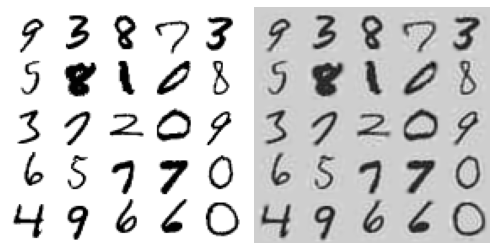

In [75]:
plt.figure(figsize=(7, 4))
plt.subplot(121)
plot_digits(X_train[::2100].values)
plt.subplot(122)
plot_digits(X_recovered_inc_pca[::2100])
plt.tight_layout()

Alternatively, you can use NumPy’s `memmap` class, which allows you to manipulate a large array stored in a binary file on disk as if it were entirely in memory; the class loads only the data it needs in memory, when it needs it. Since the `IncrementalPCA` class uses only a small part of the array at any given time, the memory usage remains under control. This makes it possible to call the usual `fit()` method, as you can see in the following code:

Let's create the `memmap()` structure and copy the MNIST data into it. This would typically be done by a first program:

In [76]:
filename = "my_mnist.data"
m, n = X_train.shape

X_mm = np.memmap(filename, dtype='float32', mode='write', shape=(m, n))
X_mm[:] = X_train

Now deleting the `memmap()` object will trigger its Python finalizer, which ensures that the data is saved to disk.

In [77]:
n_batches = 100
batch_size = m // n_batches
inc_pca = IncrementalPCA(n_components=154, batch_size=batch_size)
inc_pca.fit(X_mm)

IncrementalPCA(batch_size=525, n_components=154)

### Kernel PCA  


In Chapter 5 we discussed the kernel trick, a mathematical technique that implicitly maps instances into a very high-dimensional space (called the *feature space*), enabling nonlinear classification and regression with Support Vector Machines. Recall that a linear decision boundary in the high-dimensional feature space corresponds to a complex nonlinear decision boundary in the original space.

It turns out that the same trick can be applied to PCA, making it possible to perform complex nonlinear projections for dimensionality reduction. This is called *Kernel PCA (kPCA)*. It is often good at preserving clusters of instances after projection, or sometimes even unrolling datasets that lie close to a twisted manifold.

The following code uses Scikit-Learn’s `KernelPCA` class to perform kPCA with an RBF kernel (see Chapter 5 for more details about the RBF kernel and other kernels):

In [78]:
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

In [79]:
from sklearn.decomposition import KernelPCA

rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.04)
X_reduced = rbf_pca.fit_transform(X)

Saving figure kernel_pca_plot


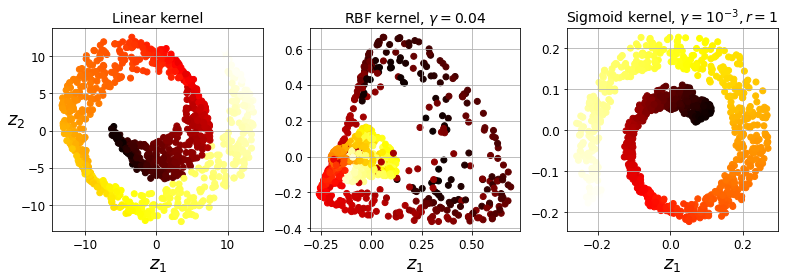

In [80]:
from sklearn.decomposition import KernelPCA

lin_pca = KernelPCA(n_components = 2, kernel="linear", fit_inverse_transform=True)
rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.0433, fit_inverse_transform=True)
sig_pca = KernelPCA(n_components = 2, kernel="sigmoid", gamma=0.001, coef0=1, fit_inverse_transform=True)

y = t > 6.9

plt.figure(figsize=(11, 4))
for subplot, pca, title in ((131, lin_pca, "Linear kernel"), 
                            (132, rbf_pca, "RBF kernel, $\gamma=0.04$"), 
                            (133, sig_pca, "Sigmoid kernel, $\gamma=10^{-3}, r=1$")):
    X_reduced = pca.fit_transform(X)
    if subplot == 132:
        X_reduced_rbf = X_reduced
    
    plt.subplot(subplot)
    #plt.plot(X_reduced[y, 0], X_reduced[y, 1], "gs")
    #plt.plot(X_reduced[~y, 0], X_reduced[~y, 1], "y^")
    plt.title(title, fontsize=14)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
    plt.xlabel("$z_1$", fontsize=18)
    if subplot == 131:
        plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.grid(True)

save_fig("kernel_pca_plot")
plt.show()

**Selecting a Kernel and Tuning Hyperparameters**  


As kPCA is an unsupervised learning algorithm, there is no obvious performance measure to help you select the best kernel and hyperparameter values. That said, dimensionality reduction is often a preparation step for a supervised learning task (e.g., classification), so you can use grid search to select the kernel and hyperparameters that lead to the best performance on that task. The following code creates a two-step pipeline, first reducing dimensionality to two dimensions using kPCA, then applying Logistic Regression for classification. Then it uses `GridSearchCV` to find the best kernel and `gamma` value for kPCA in order to get the best classification accuracy at the end of the pipeline:

In [81]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

clf = Pipeline([
        ("kpca", KernelPCA(n_components=2)),
        ("log_reg", LogisticRegression(solver="lbfgs"))
    ])

param_grid = [{
        "kpca__gamma": np.linspace(0.03, 0.05, 10),
        "kpca__kernel": ["rbf", "sigmoid"]
    }]

grid_search = GridSearchCV(clf, param_grid, cv=3)
grid_search.fit(X, y)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('kpca', KernelPCA(n_components=2)),
                                       ('log_reg', LogisticRegression())]),
             param_grid=[{'kpca__gamma': array([0.03      , 0.03222222, 0.03444444, 0.03666667, 0.03888889,
       0.04111111, 0.04333333, 0.04555556, 0.04777778, 0.05      ]),
                          'kpca__kernel': ['rbf', 'sigmoid']}])

In [82]:
print(grid_search.best_params_)

{'kpca__gamma': 0.043333333333333335, 'kpca__kernel': 'rbf'}


Another approach, this time entirely unsupervised, is to select the kernel and hyperparameters that yield the lowest reconstruction error. Note that reconstruction is not as easy as with linear PCA. Here’s why. Figure 8-11 shows the original Swiss roll 3D dataset (original space) and the resulting 2D dataset after kPCA is applied using an RBF kernel (reduced space). Thanks to the kernel trick, this transformation is mathematically equivalent to using the *feature map φ* to map the training set to an infinite-dimensional feature space (bottom right), then projecting the transformed training set down to 2D using linear PCA.

Notice that if we could invert the linear PCA step for a given instance in the reduced space, the reconstructed point would lie in feature space, not in the original space (e.g., like the one represented by an X in the diagram). Since the feature space is infinite-dimensional, we cannot compute the reconstructed point, and therefore we cannot compute the true reconstruction error. Fortunately, it is possible to find a point in the original space that would map close to the reconstructed point. This point is called the *reconstruction pre-image*. Once you have this pre-image, you can measure its squared distance to the original instance. You can then select the kernel and hyperparameters that minimize this reconstruction pre-image error.

In [83]:
rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.0433,
                    fit_inverse_transform=True)
X_reduced = rbf_pca.fit_transform(X)
X_preimage = rbf_pca.inverse_transform(X_reduced)

In [84]:
from sklearn.metrics import mean_squared_error

mean_squared_error(X, X_preimage)

32.7863087957661

Saving figure preimage_plot


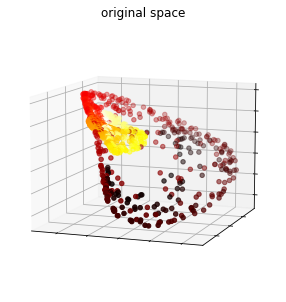

In [85]:
plt.figure(figsize=(6, 5))

X_inverse = rbf_pca.inverse_transform(X_reduced_rbf)

ax = plt.subplot(111, projection='3d')
ax.view_init(10, -70)
ax.scatter(X_inverse[:, 0], X_inverse[:, 1], X_inverse[:, 2], c=t, cmap=plt.cm.hot, marker="o")
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_zlabel("")
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
ax.set_title("original space")

save_fig("preimage_plot", tight_layout=False)
plt.show()

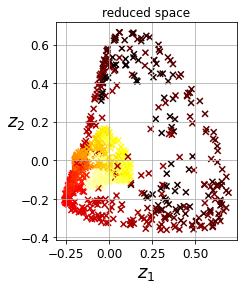

In [86]:
X_reduced = rbf_pca.fit_transform(X)

plt.figure(figsize=(11, 4))
plt.subplot(132)
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot, marker="x")
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.title("reduced space")
plt.grid(True)

You would test your program and repeat steps 1 and 2 until it was good enough to launch.

<img src="./chapters/8/0811.png" width = 600>
<div style="text-align:left"> Figure 8-11. Kernel PCA and the reconstruction pre-image error </div>

You may be wondering how to perform this reconstruction. One solution is to train a supervised regression model, with the projected instances as the training set and the original instances as the targets. Scikit-Learn will do this automatically if you set `fit_inverse_transform=True`, as shown in the following code:

In [87]:
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

In [88]:
rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.0433,
                    fit_inverse_transform=True)
X_reduced = rbf_pca.fit_transform(X)
X_preimage = rbf_pca.inverse_transform(X_reduced)

In [89]:
from sklearn.metrics import mean_squared_error
mean_squared_error(X, X_preimage)

32.78630879576608

**Time complexity**

Let's time regular PCA against Incremental PCA and Randomized PCA, for various number of principal components:

In [90]:
import time

for n_components in (2, 10, 154):
    print("n_components =", n_components)
    regular_pca = PCA(n_components=n_components)
    inc_pca = IncrementalPCA(n_components=n_components, batch_size=500)
    rnd_pca = PCA(n_components=n_components, random_state=42, svd_solver="randomized")

    for pca in (regular_pca, inc_pca, rnd_pca):
        t1 = time.time()
        pca.fit(X_train)
        t2 = time.time()
        print("    {}: {:.1f} seconds".format(pca.__class__.__name__, t2 - t1))

n_components = 2
    PCA: 2.1 seconds
    IncrementalPCA: 43.6 seconds
    PCA: 2.1 seconds
n_components = 10
    PCA: 2.4 seconds
    IncrementalPCA: 44.1 seconds
    PCA: 2.2 seconds
n_components = 154
    PCA: 12.9 seconds
    IncrementalPCA: 71.0 seconds
    PCA: 13.3 seconds


Now let's compare PCA and Randomized PCA for datasets of different sizes (number of instances):

Text(0.5, 1.0, 'PCA and Randomized PCA time complexity ')

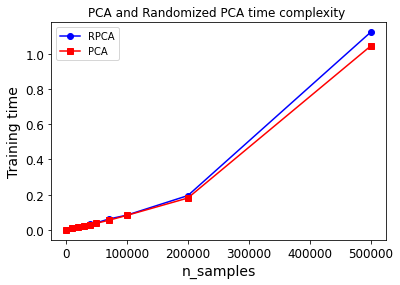

In [91]:
times_rpca = []
times_pca = []
sizes = [1000, 10000, 20000, 30000, 40000, 50000, 70000, 100000, 200000, 500000]
for n_samples in sizes:
    X = np.random.randn(n_samples, 5)
    pca = PCA(n_components = 2, svd_solver="randomized", random_state=42)
    t1 = time.time()
    pca.fit(X)
    t2 = time.time()
    times_rpca.append(t2 - t1)
    pca = PCA(n_components = 2)
    t1 = time.time()
    pca.fit(X)
    t2 = time.time()
    times_pca.append(t2 - t1)

plt.plot(sizes, times_rpca, "b-o", label="RPCA")
plt.plot(sizes, times_pca, "r-s", label="PCA")
plt.xlabel("n_samples")
plt.ylabel("Training time")
plt.legend(loc="upper left")
plt.title("PCA and Randomized PCA time complexity ")

And now let's compare their performance on datasets of 2,000 instances with various numbers of features:

Text(0.5, 1.0, 'PCA and Randomized PCA time complexity ')

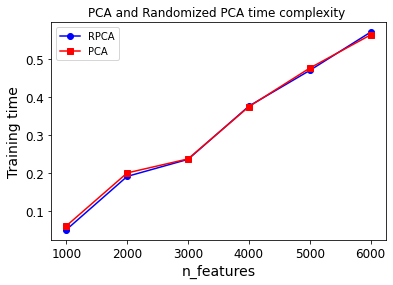

In [92]:
times_rpca = []
times_pca = []
sizes = [1000, 2000, 3000, 4000, 5000, 6000]
for n_features in sizes:
    X = np.random.randn(2000, n_features)
    pca = PCA(n_components = 2, random_state=42, svd_solver="randomized")
    t1 = time.time()
    pca.fit(X)
    t2 = time.time()
    times_rpca.append(t2 - t1)
    pca = PCA(n_components = 2)
    t1 = time.time()
    pca.fit(X)
    t2 = time.time()
    times_pca.append(t2 - t1)

plt.plot(sizes, times_rpca, "b-o", label="RPCA")
plt.plot(sizes, times_pca, "r-s", label="PCA")
plt.xlabel("n_features")
plt.ylabel("Training time")
plt.legend(loc="upper left")
plt.title("PCA and Randomized PCA time complexity ")

## LLE

*Locally Linear Embedding (LLE)* is another powerful *nonlinear dimensionality reduction (NLDR)* technique. It is a Manifold Learning technique that does not rely on projections, like the previous algorithms do. In a nutshell, LLE works by first measuring how each training instance linearly relates to its closest neighbors (c.n.), and then looking for a low-dimensional representation of the training set where these local relationships are best preserved (more details shortly). This approach makes it particularly good at unrolling twisted manifolds, especially when there is not too much noise.

The following code uses Scikit-Learn’s `LocallyLinearEmbedding` class to unroll the Swiss roll:

In [93]:
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=41)

In [94]:
from sklearn.manifold import LocallyLinearEmbedding

lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10, random_state=42)
X_reduced = lle.fit_transform(X)

Saving figure lle_unrolling_plot


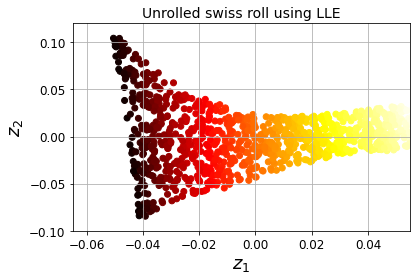

In [95]:
plt.title("Unrolled swiss roll using LLE", fontsize=14)
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18)
plt.axis([-0.065, 0.055, -0.1, 0.12])
plt.grid(True)

save_fig("lle_unrolling_plot")
plt.show()

Figure 8-12. Unrolled Swiss roll using LLE

Here’s how LLE works: for each training instance $\mathbf x^{(i)}$, the algorithm identifies its k closest neighbors (in the preceding code k = 10), then tries to reconstruct $\mathbf x^{(i)}$ as a linear function of these neighbors. More specifically, it finds the weights $w_{i,j}$ such that the squared distance between $\mathbf x^{(i)}$ and $\sum_{j=1}^{m}w_{i,j}\mathbf x^{(j)}$ is as small as possible, assuming $w_{i,j}=0$ if $\mathbf x^{(j)}$ is not one of the k closest neighbors of $\mathbf x^{(i)}$. Thus the first step of LLE is the constrained optimization problem described in Equation 8-4, where $\mathbf W$ is the weight matrix containing all the weights $w_{i,j}$. The second constraint simply normalizes the weights for each training instance $\mathbf x^{(i)}$. 

*Equation 8-4. LLE step one: linearly modeling local relationships*  


$$\widehat{\mathbf W}=\underset{\mathbf W}{\text{argmin }}\sum_{i=1}^{m}\left(\mathbf x^{(i)}-\sum_{j=1}^{m}w_{i,j}\mathbf x^{(j)}\right)^2$$
$$\text{subject to }\begin{cases}
w_{i,j}=0, & \text{if } x^{(j)} \text{is not one of the k c.n. of } x^{(i)} \\
\sum_{i=1}^{m}w_{i,j}=1, & \text{for }  i=1,2,\cdots,m\\
\end{cases}$$

After this step, the weight matrix $\widehat{\mathbf W}$ (containing the weights $w_{i,j}$) encodes the local linear relationships between the training instances. 

The second step is to map the training instances into a d-dimensional space (where d < n) while preserving these local relationships as much as possible. If $\mathbf z^{(i)}$ is the image of $\mathbf x^{(i)}$ in this d-dimensional space, then we want the squared distance between $\mathbf z^{(i)}$ and $\sum_{j=1}^{m}w_{i,j}\mathbf z^{(j)}$ to be as small as possible. This idea leads to the unconstrained optimization problem described in Equation 8-5. It looks very similar to the first step, but instead of keeping the instances fixed and finding the optimal weights, we are doing the reverse: keeping the weights fixed and finding the optimal position of the instances’ images in the low-dimensional space. Note that $\mathbf Z$ is the matrix containing all $\mathbf z^{(i)}$.

*Equation 8-5. LLE step two: reducing dimensionality while preserving relationships*


$$\widehat{\mathbf Z} = \underset{\mathbf Z}{\text{argmin }}\sum_{i=1}^{m}\left(\mathbf z^{(i)}-\sum_{j=1}^{m}\hat w_{i,j}\mathbf z^{(j)}\right)^2$$

Scikit-Learn’s LLE implementation has the following computational complexity: $O(m \log(m)n \log(k))$ for finding the k nearest neighbors, $O(mnk^3)$ for optimizing the weights, and $O(dm^2)$ for constructing the low-dimensional representations. Unfortunately, the $m^2$ in the last term makes this algorithm scale poorly to very large datasets.

## MDS, Isomap and t-SNE

*Random Projections*  

As its name suggests, projects the data to a lower-dimensional space using a random linear projection. This may sound crazy, but it turns out that such a random projection is actually very likely to preserve distances well, as was demonstrated mathematically by William B. Johnson and Joram Lindenstrauss in a famous lemma. The quality of the dimensionality reduction depends on the number of instances and the target dimensionality, but surprisingly not on the initial dimensionality. Check out the documentation for the `sklearn.random_projection` package for more details.

*Multidimensional Scaling (MDS)*  

Reduces dimensionality while trying to preserve the distances between the instances.

*Isomap*  


Creates a graph by connecting each instance to its nearest neighbors, then reduces dimensionality while trying to preserve the geodesic distances between the instances.

*t-Distributed Stochastic Neighbor Embedding (t-SNE)*  

Reduces dimensionality while trying to keep similar instances close and dissimilar instances apart. It is mostly used for visualization, in particular to visualize clusters of instances in high-dimensional space (e.g., to visualize the MNIST images in 2D).

*Linear Discriminant Analysis (LDA)*  

Is a classification algorithm, but during training it learns the most discriminative axes between the classes, and these axes can then be used to define a hyperplane onto which to project the data. The benefit of this approach is that the projection will keep classes as far apart as possible, so LDA is a good technique to reduce dimensionality before running another classification algorithm such as an SVM classifier.

In [96]:
from sklearn.manifold import MDS

mds = MDS(n_components=2, random_state=42)
X_reduced_mds = mds.fit_transform(X)

In [97]:
from sklearn.manifold import Isomap

isomap = Isomap(n_components=2)
X_reduced_isomap = isomap.fit_transform(X)

In [98]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
X_reduced_tsne = tsne.fit_transform(X)

/home/dan/miniconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/dan/miniconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [99]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis(n_components=2)
X_mnist = mnist["data"]
y_mnist = mnist["target"]
lda.fit(X_mnist, y_mnist)
X_reduced_lda = lda.transform(X_mnist)

Saving figure other_dim_reduction_plot


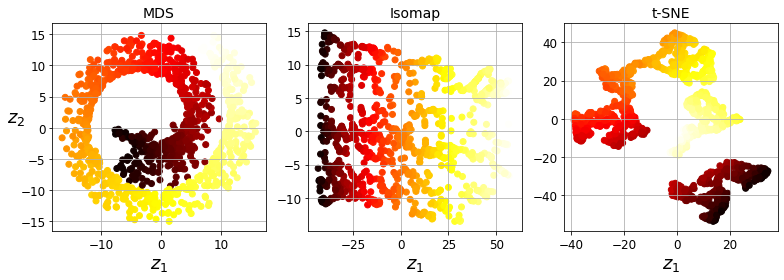

In [100]:
titles = ["MDS", "Isomap", "t-SNE"]

plt.figure(figsize=(11,4))

for subplot, title, X_reduced in zip((131, 132, 133), titles,
                                     (X_reduced_mds, X_reduced_isomap, X_reduced_tsne)):
    plt.subplot(subplot)
    plt.title(title, fontsize=14)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
    plt.xlabel("$z_1$", fontsize=18)
    if subplot == 131:
        plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.grid(True)

save_fig("other_dim_reduction_plot")
plt.show()

Figure 8-13. Using various techniques to reduce the Swill roll to 2D

## Exercise solutions

1. What are the main motivations for reducing a dataset’s dimensionality? What are the main drawbacks?

>The main motivations for dimensionality reduction are:

 > - To speed up a subsequent training algorithm (in some cases it may even remove noise and redundant features, making the training algorithm perform better)
 > - To visualize the data and gain insights on the most important features
 > - To save space (compression)

>The main drawbacks are:

 > - Some information is lost, possibly degrading the performance of subsequent training algorithms.
 > - It can be computationally intensive.
 > - It adds some complexity to your Machine Learning pipelines.
 > - Transformed features are often hard to interpret.

2. What is the curse of dimensionality?

>The curse of dimensionality refers to the fact that many problems that do not exist in low-dimensional space arise in high-dimensional space. In Machine Learning, one common manifestation is the fact that randomly sampled high-dimensional vectors are generally very sparse, increasing the risk of overfitting and making it very difficult to identify patterns in the data without having plenty of training data.

3. Once a dataset’s dimensionality has been reduced, is it possible to reverse the operation? If so, how? If not, why?

>Once a dataset’s dimensionality has been reduced using one of the algorithms we discussed, it is almost always impossible to perfectly reverse the operation, because some information gets lost during dimensionality reduction. Moreover, while some algorithms (such as PCA) have a simple reverse transformation procedure that can reconstruct a dataset relatively similar to the original, other algorithms (such as T-SNE) do not.



4. Can PCA be used to reduce the dimensionality of a highly nonlinear dataset?

>PCA can be used to significantly reduce the dimensionality of most datasets, even if they are highly nonlinear, because it can at least get rid of useless dimensions. However, if there are no useless dimensions—as in a Swiss roll dataset—then reducing dimensionality with PCA will lose too much information. You want to unroll the Swiss roll, not squash it.

5. Suppose you perform PCA on a 1,000-dimensional dataset, setting the explained variance ratio to 95%. How many dimensions will the resulting dataset have?

>That’s a trick question: it depends on the dataset. Let’s look at two extreme examples. First, suppose the dataset is composed of points that are almost perfectly aligned. In this case, PCA can reduce the dataset down to just one dimension while still preserving 95% of the variance. Now imagine that the dataset is composed of perfectly random points, scattered all around the 1,000 dimensions. In this case roughly 950 dimensions are required to preserve 95% of the variance. So the answer is, it depends on the dataset, and it could be any number between 1 and 950. Plotting the explained variance as a function of the number of dimensions is one way to get a rough idea of the dataset’s intrinsic dimensionality.

6. In what cases would you use vanilla PCA, Incremental PCA, Randomized PCA, or Kernel PCA?

>Regular PCA is the default, but it works only if the dataset fits in memory. Incremental PCA is useful for large datasets that don’t fit in memory, but it is slower than regular PCA, so if the dataset fits in memory you should prefer regular PCA. Incremental PCA is also useful for online tasks, when you need to apply PCA on the fly, every time a new instance arrives. Randomized PCA is useful when you want to considerably reduce dimensionality and the dataset fits in memory; in this case, it is much faster than regular PCA. Finally, Kernel PCA is useful for nonlinear datasets.

7. How can you evaluate the performance of a dimensionality reduction algorithm on your dataset?

>Intuitively, a dimensionality reduction algorithm performs well if it eliminates a lot of dimensions from the dataset without losing too much information. One way to measure this is to apply the reverse transformation and measure the reconstruction error. However, not all dimensionality reduction algorithms provide a reverse transformation. Alternatively, if you are using dimensionality reduction as a preprocessing step before another Machine Learning algorithm (e.g., a Random Forest classifier), then you can simply measure the performance of that second algorithm; if dimensionality reduction did not lose too much information, then the algorithm should perform just as well as when using the original dataset.


8. Does it make any sense to chain two different dimensionality reduction algorithms?

>It can absolutely make sense to chain two different dimensionality reduction algorithms. A common example is using PCA to quickly get rid of a large number of useless dimensions, then applying another much slower dimensionality reduction algorithm, such as LLE. This two-step approach will likely yield the same performance as using LLE only, but in a fraction of the time.

9. Load the MNIST dataset (introduced in Chapter 3) and split it into a training set and a test set (take the first 60,000 instances for training, and the remaining 10,000 for testing). Train a Random Forest classifier on the dataset and time how long it takes, then evaluate the resulting model on the test set. Next, use PCA to reduce the dataset’s dimensionality, with an explained variance ratio of 95%. Train a new Random Forest classifier on the reduced dataset and see how long it takes. Was training much faster? Next, evaluate the classifier on the test set. How does it compare to the previous classifier?

*Exercise: Load the MNIST dataset (introduced in chapter 3) and split it into a training set and a test set (take the first 60,000 instances for training, and the remaining 10,000 for testing).*

The MNIST dataset was loaded earlier.

In [101]:
X_train = mnist['data'][:60000]
y_train = mnist['target'][:60000]

X_test = mnist['data'][60000:]
y_test = mnist['target'][60000:]

*Exercise: Train a Random Forest classifier on the dataset and time how long it takes, then evaluate the resulting model on the test set.*

In [102]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)

In [103]:
import time

t0 = time.time()
rnd_clf.fit(X_train, y_train)
t1 = time.time()

In [104]:
print("Training took {:.2f}s".format(t1 - t0))

Training took 32.19s


In [105]:
from sklearn.metrics import accuracy_score

y_pred = rnd_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.9705

*Exercise: Next, use PCA to reduce the dataset's dimensionality, with an explained variance ratio of 95%.*

In [106]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95)
X_train_reduced = pca.fit_transform(X_train)

*Exercise: Train a new Random Forest classifier on the reduced dataset and see how long it takes. Was training much faster?*

In [107]:
rnd_clf2 = RandomForestClassifier(n_estimators=100, random_state=42)
t0 = time.time()
rnd_clf2.fit(X_train_reduced, y_train)
t1 = time.time()

In [108]:
print("Training took {:.2f}s".format(t1 - t0))

Training took 75.35s


Oh no! Training is actually more than twice slower now! How can that be? Well, as we saw in this chapter, dimensionality reduction does not always lead to faster training time: it depends on the dataset, the model and the training algorithm. See figure 8-6 (the `manifold_decision_boundary_plot*` plots above). If you try a softmax classifier instead of a random forest classifier, you will find that training time is reduced by a factor of 3 when using PCA. Actually, we will do this in a second, but first let's check the precision of the new random forest classifier.

*Exercise: Next evaluate the classifier on the test set: how does it compare to the previous classifier?*

In [109]:
X_test_reduced = pca.transform(X_test)

y_pred = rnd_clf2.predict(X_test_reduced)
accuracy_score(y_test, y_pred)

0.9481

It is common for performance to drop slightly when reducing dimensionality, because we do lose some useful signal in the process. However, the performance drop is rather severe in this case. So PCA really did not help: it slowed down training and reduced performance. :(

Let's see if it helps when using softmax regression:

In [110]:
from sklearn.linear_model import LogisticRegression

log_clf = LogisticRegression(multi_class="multinomial", solver="lbfgs", random_state=42)
t0 = time.time()
log_clf.fit(X_train, y_train)
t1 = time.time()

/home/dan/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [111]:
print("Training took {:.2f}s".format(t1 - t0))

Training took 17.86s


In [112]:
y_pred = log_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.9255

Okay, so softmax regression takes much longer to train on this dataset than the random forest classifier, plus it performs worse on the test set. But that's not what we are interested in right now, we want to see how much PCA can help softmax regression. Let's train the softmax regression model using the reduced dataset:

In [113]:
log_clf2 = LogisticRegression(multi_class="multinomial", solver="lbfgs", random_state=42)
t0 = time.time()
log_clf2.fit(X_train_reduced, y_train)
t1 = time.time()

/home/dan/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [114]:
print("Training took {:.2f}s".format(t1 - t0))

Training took 7.80s


Nice! Reducing dimensionality led to a 4× speedup. :)  Let's check the model's accuracy:

In [115]:
y_pred = log_clf2.predict(X_test_reduced)
accuracy_score(y_test, y_pred)

0.9201

A very slight drop in performance, which might be a reasonable price to pay for a 4× speedup, depending on the application.

So there you have it: PCA can give you a formidable speedup... but not always!

10. Use t-SNE to reduce the MNIST dataset down to two dimensions and plot the result using Matplotlib. You can use a scatterplot using 10 different colors to represent each image’s target class. Alternatively, you can replace each dot in the scatterplot with the corresponding instance’s class (a digit from 0 to 9), or even plot scaled-down versions of the digit images themselves (if you plot all digits, the visualization will be too cluttered, so you should either draw a random sample or plot an instance only if no other instance has already been plotted at a close distance). You should get a nice visualization with well-separated clusters of digits. Try using other dimensionality reduction algorithms such as PCA, LLE, or MDS and compare the resulting visualizations.

*Exercise: Use t-SNE to reduce the MNIST dataset down to two dimensions and plot the result using Matplotlib. You can use a scatterplot using 10 different colors to represent each image's target class.*

The MNIST dataset was loaded above.

Dimensionality reduction on the full 60,000 images takes a very long time, so let's only do this on a random subset of 10,000 images:

In [116]:
np.random.seed(42)

m = 10000
idx = np.random.permutation(60000)[:m]

X = mnist['data'].iloc[idx]
y = mnist['target'].iloc[idx]

Now let's use t-SNE to reduce dimensionality down to 2D so we can plot the dataset:

In [117]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
X_reduced = tsne.fit_transform(X)

/home/dan/miniconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/dan/miniconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Now let's use Matplotlib's `scatter()` function to plot a scatterplot, using a different color for each digit:

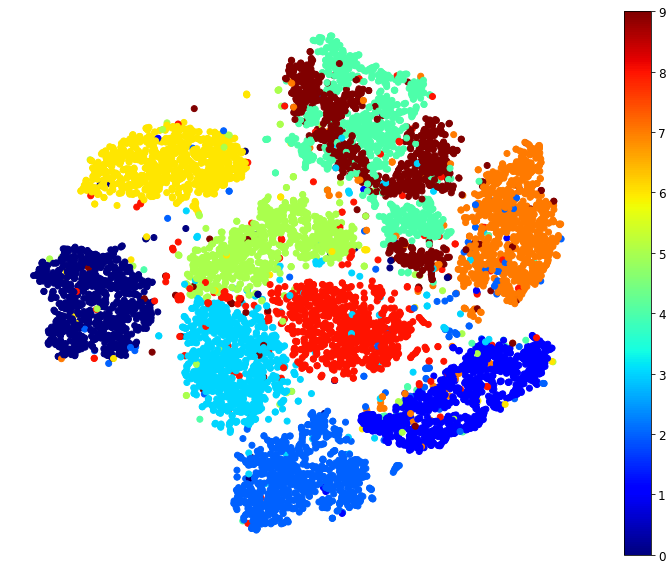

In [118]:
plt.figure(figsize=(13,10))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, cmap="jet")
plt.axis('off')
plt.colorbar()
plt.show()

Isn't this just beautiful? :) This plot tells us which numbers are easily distinguishable from the others (e.g., 0s, 6s, and most 8s are rather well separated clusters), and it also tells us which numbers are often hard to distinguish (e.g., 4s and 9s, 5s and 3s, and so on).

Let's focus on digits 3 and 5, which seem to overlap a lot.

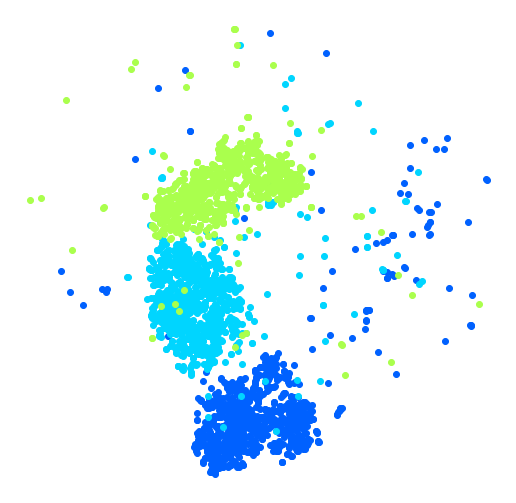

In [119]:
plt.figure(figsize=(9,9))
cmap = mpl.cm.get_cmap("jet")
for digit in (2, 3, 5):
    plt.scatter(X_reduced[y == digit, 0], X_reduced[y == digit, 1], c=[cmap(digit / 9)])
plt.axis('off')
plt.show()

Let's see if we can produce a nicer image by running t-SNE on these 3 digits:

In [120]:
idx = (y == 2) | (y == 3) | (y == 5) 
X_subset = X[idx]
y_subset = y[idx]

tsne_subset = TSNE(n_components=2, random_state=42)
X_subset_reduced = tsne_subset.fit_transform(X_subset)

/home/dan/miniconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/dan/miniconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


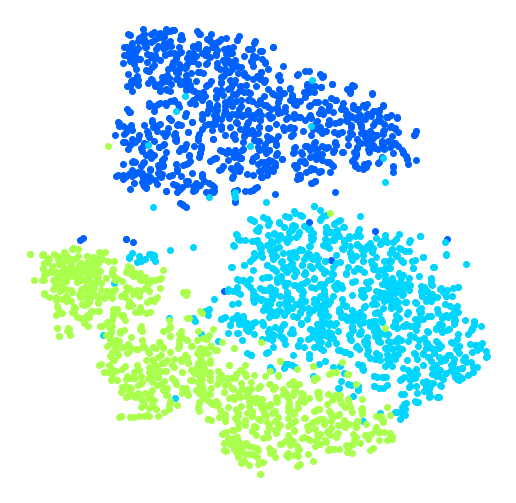

In [121]:
plt.figure(figsize=(9,9))
for digit in (2, 3, 5):
    plt.scatter(X_subset_reduced[y_subset == digit, 0], X_subset_reduced[y_subset == digit, 1], c=[cmap(digit / 9)])
plt.axis('off')
plt.show()

Much better, now the clusters have far less overlap. But some 3s are all over the place. Plus, there are two distinct clusters of 2s, and also two distinct clusters of 5s. It would be nice if we could visualize a few digits from each cluster, to understand why this is the case. Let's do that now. 

*Exercise: Alternatively, you can write colored digits at the location of each instance, or even plot scaled-down versions of the digit images themselves (if you plot all digits, the visualization will be too cluttered, so you should either draw a random sample or plot an instance only if no other instance has already been plotted at a close distance). You should get a nice visualization with well-separated clusters of digits.*

Let's create a `plot_digits()` function that will draw a scatterplot (similar to the above scatterplots) plus write colored digits, with a minimum distance guaranteed between these digits. If the digit images are provided, they are plotted instead. This implementation was inspired from one of Scikit-Learn's excellent examples ([plot_lle_digits](http://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html), based on a different digit dataset).

In [122]:
from sklearn.preprocessing import MinMaxScaler
from matplotlib.offsetbox import AnnotationBbox, OffsetImage

def plot_digits(X, y, min_distance=0.05, images=None, figsize=(13, 10)):
    # Let's scale the input features so that they range from 0 to 1
    X_normalized = MinMaxScaler().fit_transform(X)
    # Now we create the list of coordinates of the digits plotted so far.
    # We pretend that one is already plotted far away at the start, to
    # avoid `if` statements in the loop below
    neighbors = np.array([[10., 10.]])
    # The rest should be self-explanatory
    plt.figure(figsize=figsize)
    cmap = mpl.cm.get_cmap("jet")
    digits = np.unique(y)
    for digit in digits:
        plt.scatter(X_normalized[y == digit, 0], X_normalized[y == digit, 1], c=[cmap(digit / 9)])
    plt.axis("off")
    ax = plt.gcf().gca()  # get current axes in current figure
    for index, image_coord in enumerate(X_normalized):
        closest_distance = np.linalg.norm(neighbors - image_coord, axis=1).min()
        if closest_distance > min_distance:
            neighbors = np.r_[neighbors, [image_coord]]
            if images is None:
                plt.text(image_coord[0], image_coord[1], str(int(y.iloc[index])),
                         color=cmap(y.iloc[index] / 9), fontdict={"weight": "bold", "size": 16})
            else:
                image = images.iloc[index].values.reshape(28, 28)
                imagebox = AnnotationBbox(OffsetImage(image, cmap="binary"), image_coord)
                ax.add_artist(imagebox)

Let's try it! First let's just write colored digits:

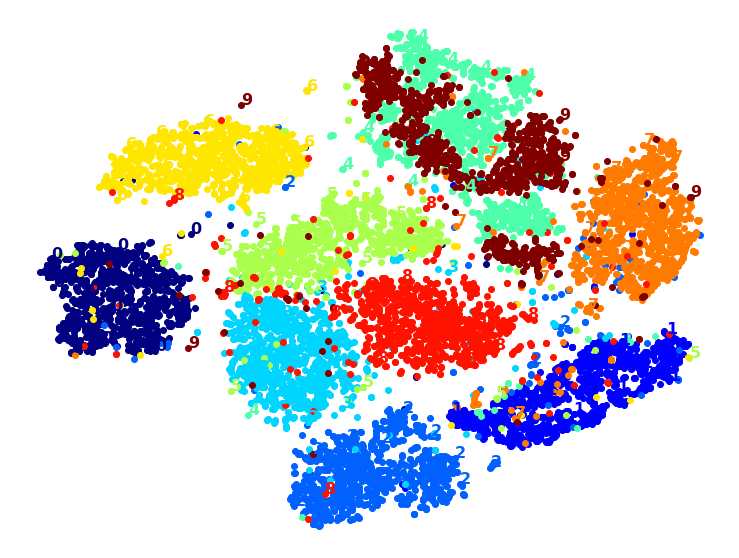

In [123]:
plot_digits(X_reduced, y)

Well that's okay, but not that beautiful. Let's try with the digit images:

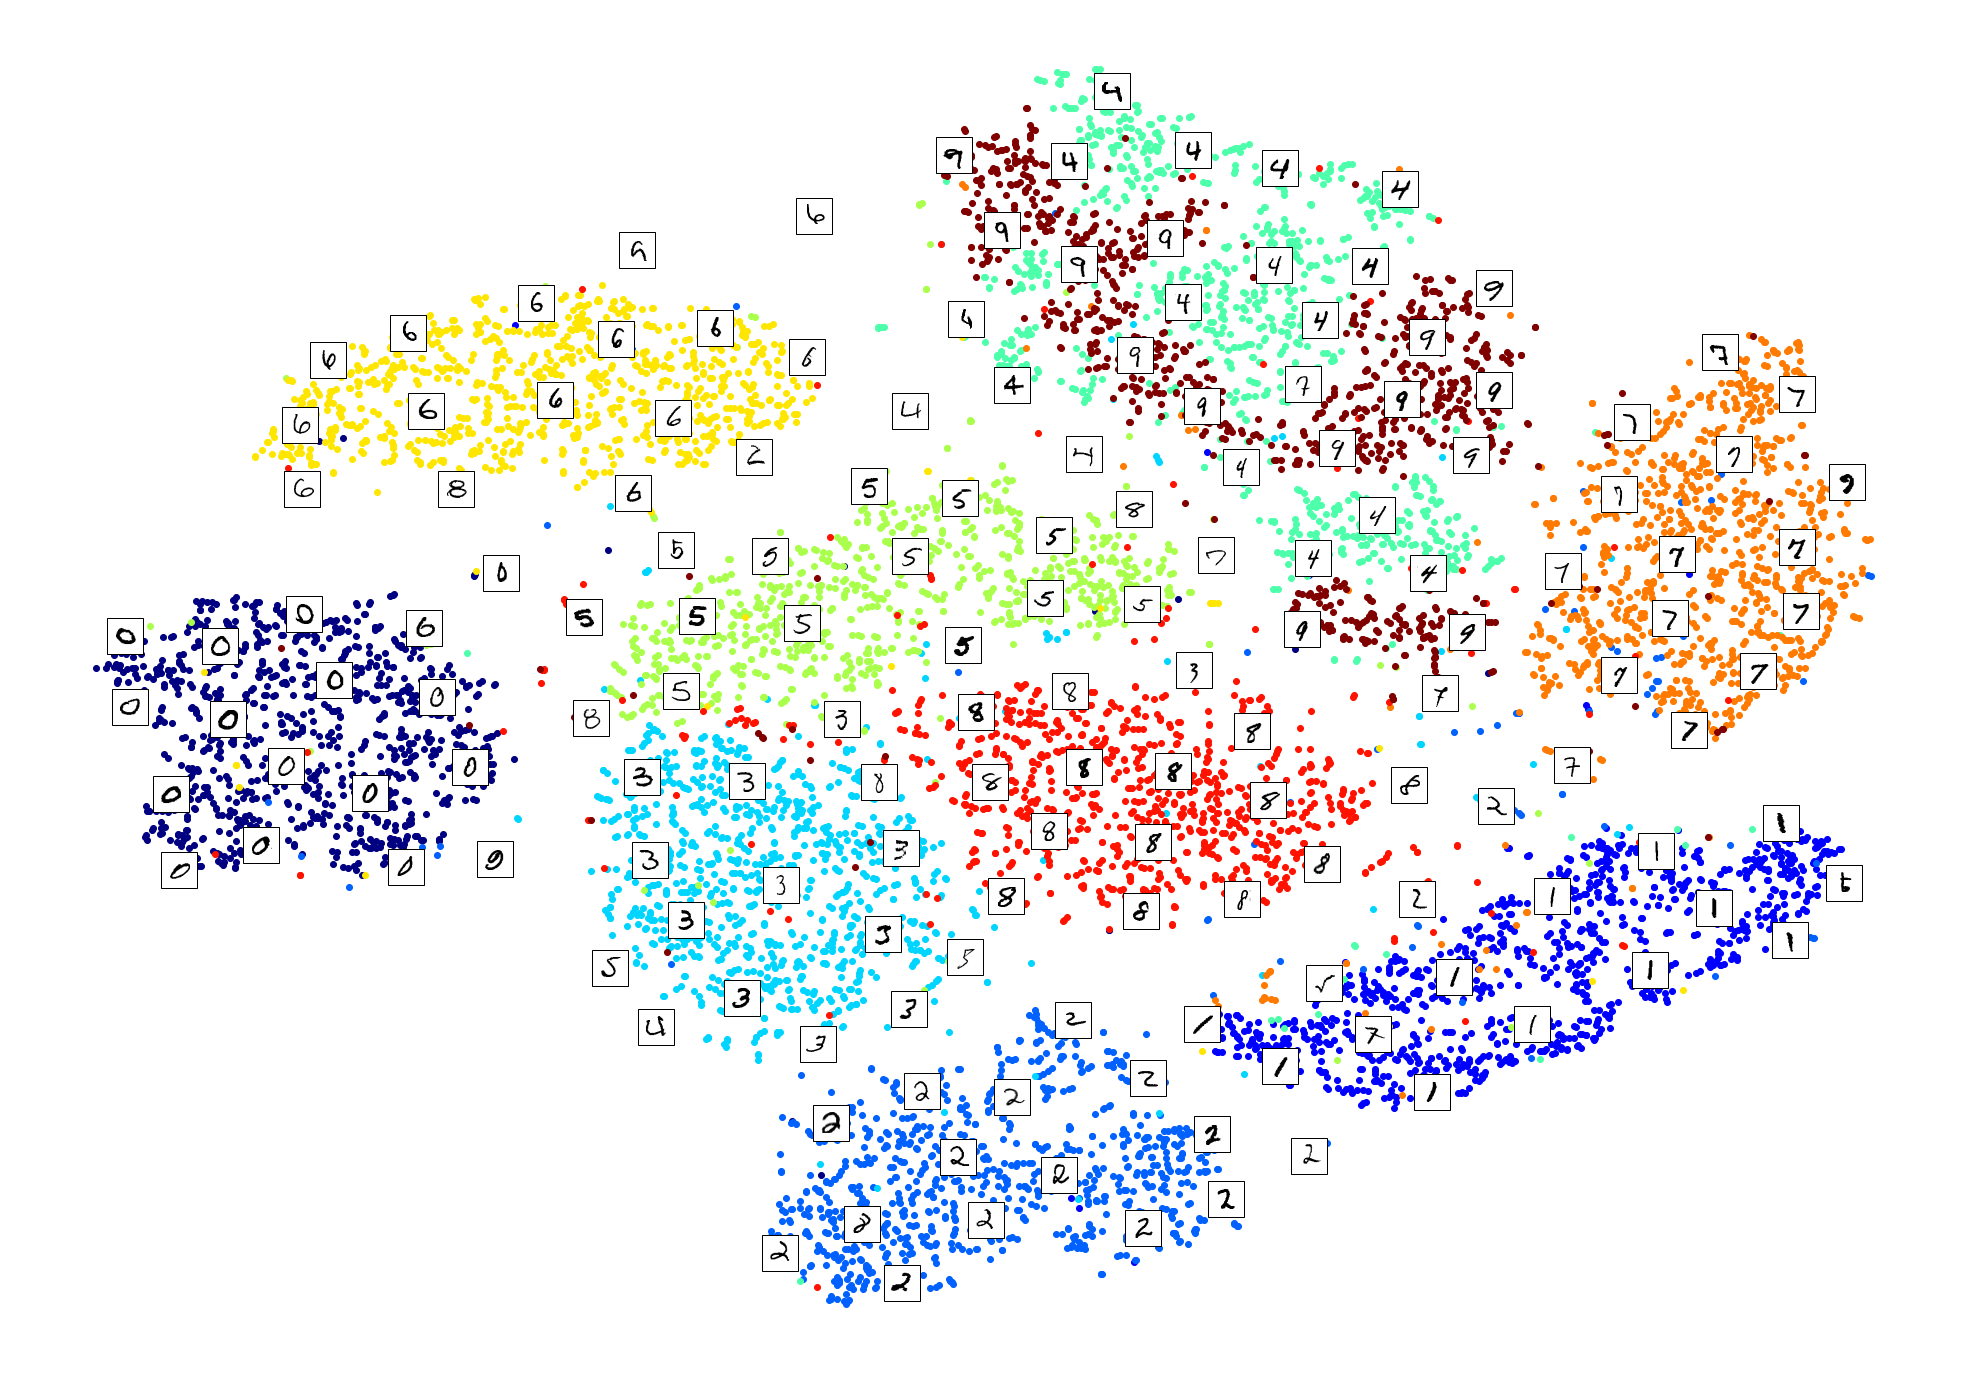

In [124]:
plot_digits(X_reduced, y, images=X, figsize=(35, 25))

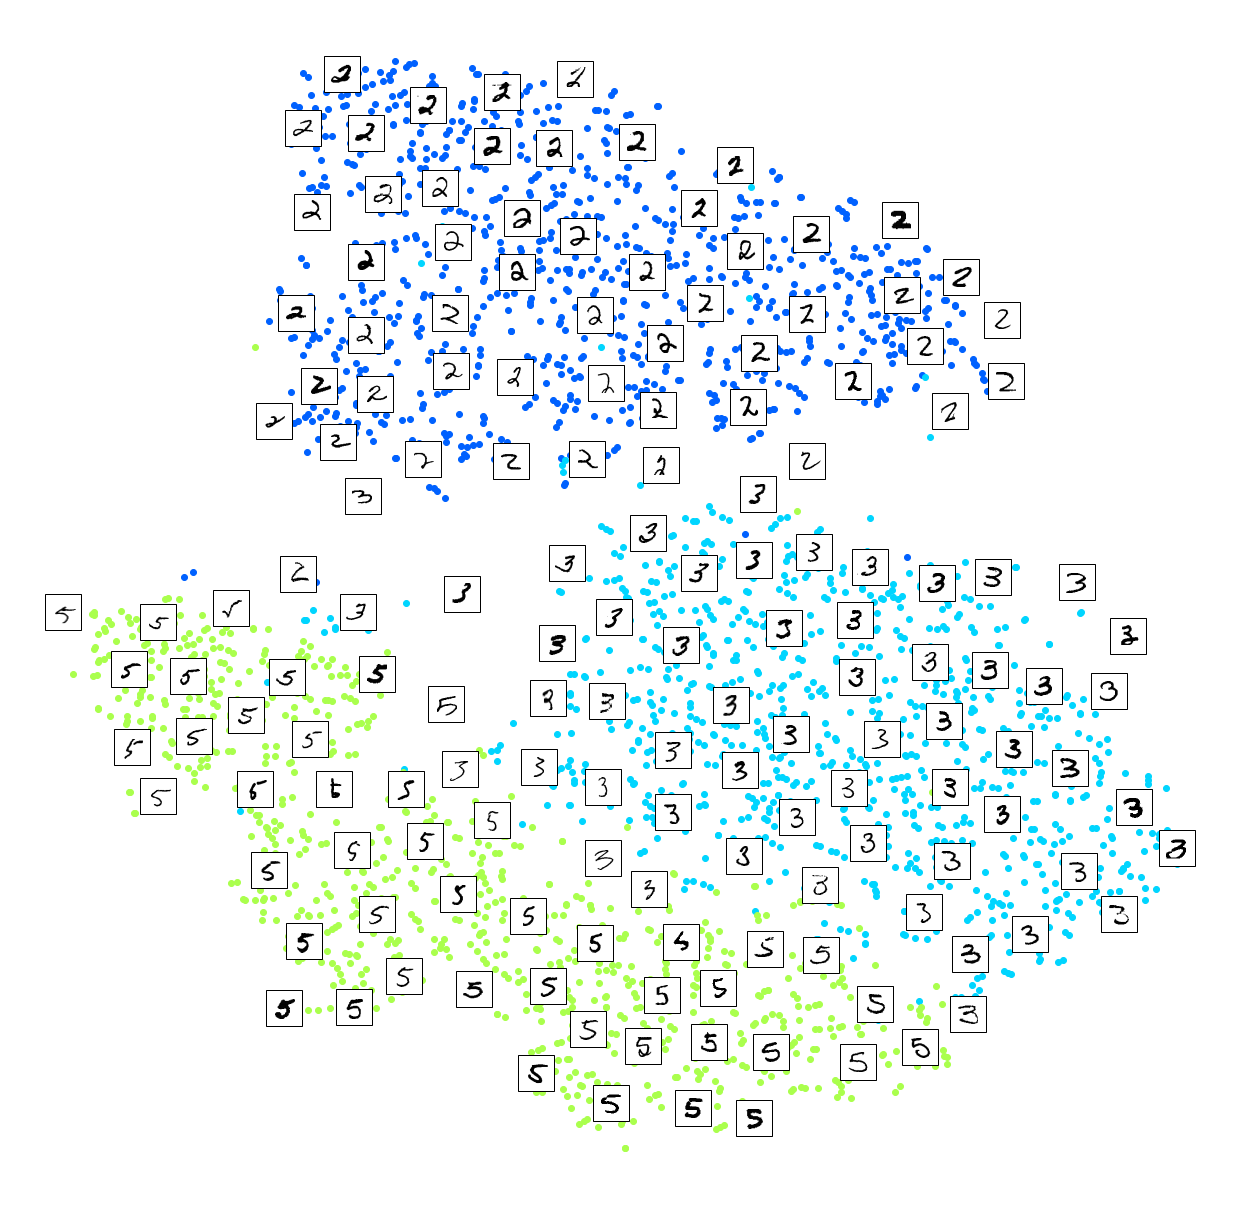

In [125]:
plot_digits(X_subset_reduced, y_subset, images=X_subset, figsize=(22, 22))

*Exercise: Try using other dimensionality reduction algorithms such as PCA, LLE, or MDS and compare the resulting visualizations.*

Let's start with PCA. We will also time how long it takes:

PCA took 0.5s.


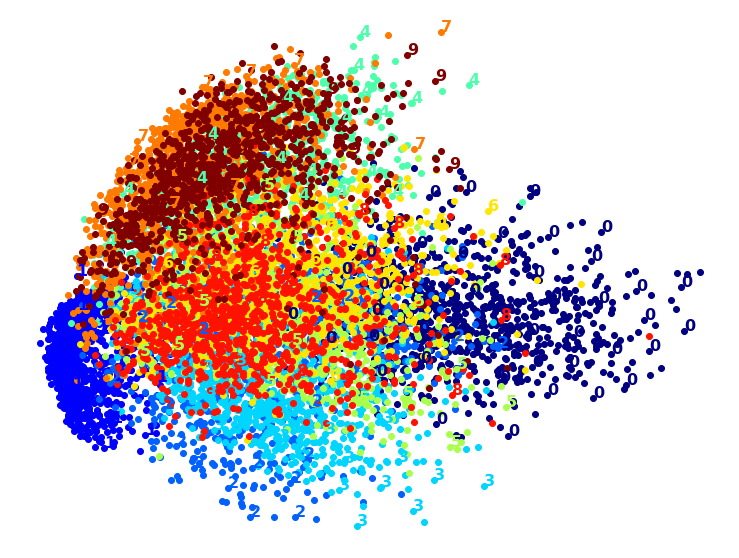

In [126]:
from sklearn.decomposition import PCA
import time

t0 = time.time()
X_pca_reduced = PCA(n_components=2, random_state=42).fit_transform(X)
t1 = time.time()
print("PCA took {:.1f}s.".format(t1 - t0))
plot_digits(X_pca_reduced, y)
plt.show()

Wow, PCA is blazingly fast! But although we do see a few clusters, there's way too much overlap. Let's try LLE:

LLE took 16.5s.


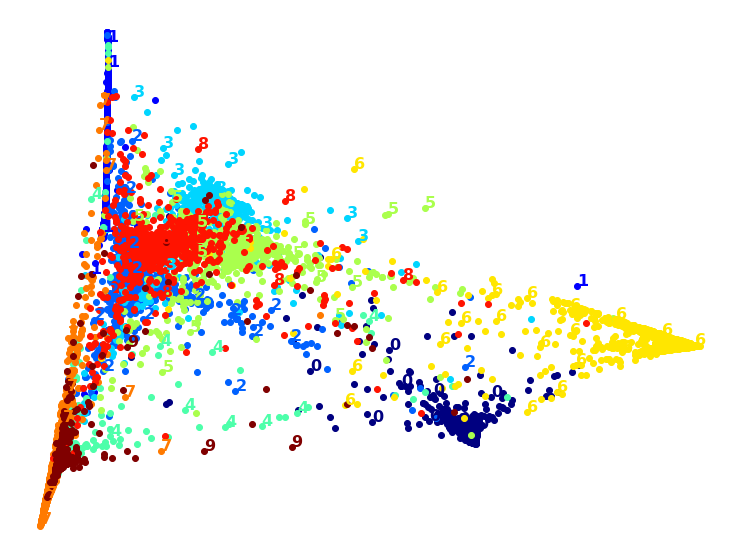

In [127]:
from sklearn.manifold import LocallyLinearEmbedding

t0 = time.time()
X_lle_reduced = LocallyLinearEmbedding(n_components=2, random_state=42).fit_transform(X)
t1 = time.time()
print("LLE took {:.1f}s.".format(t1 - t0))
plot_digits(X_lle_reduced, y)
plt.show()

That took a while, and the result does not look too good. Let's see what happens if we apply PCA first, preserving 95% of the variance:

PCA+LLE took 30.6s.


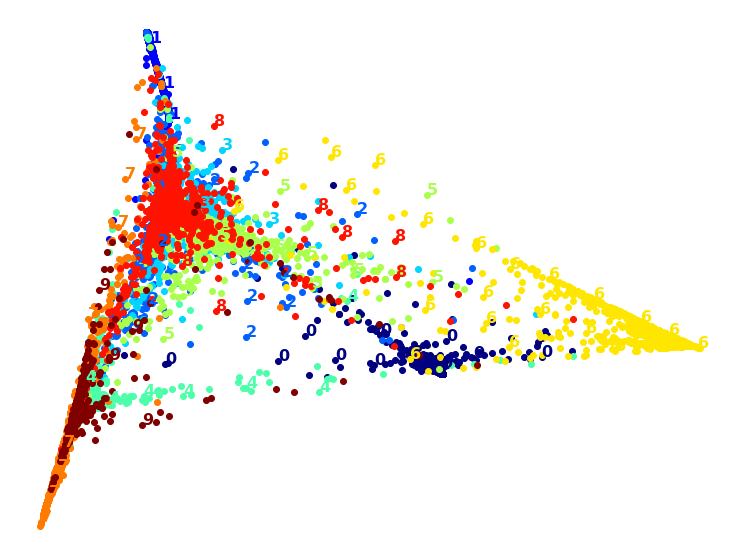

In [128]:
from sklearn.pipeline import Pipeline

pca_lle = Pipeline([
    ("pca", PCA(n_components=0.95, random_state=42)),
    ("lle", LocallyLinearEmbedding(n_components=2, random_state=42)),
])
t0 = time.time()
X_pca_lle_reduced = pca_lle.fit_transform(X)
t1 = time.time()
print("PCA+LLE took {:.1f}s.".format(t1 - t0))
plot_digits(X_pca_lle_reduced, y)
plt.show()

The result is more or less the same, but this time it was almost 4× faster.

Let's try MDS. It's much too long if we run it on 10,000 instances, so let's just try 2,000 for now:

MDS took 144.9s (on just 2,000 MNIST images instead of 10,000).


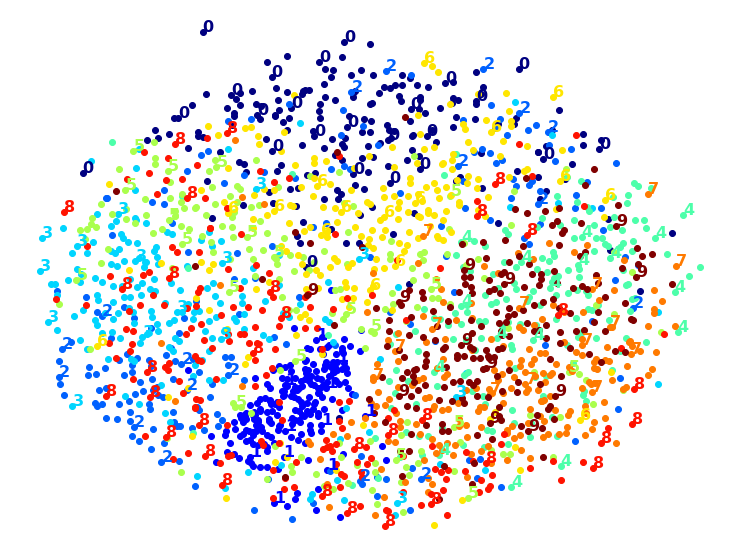

In [129]:
from sklearn.manifold import MDS

m = 2000
t0 = time.time()
X_mds_reduced = MDS(n_components=2, random_state=42).fit_transform(X[:m])
t1 = time.time()
print("MDS took {:.1f}s (on just 2,000 MNIST images instead of 10,000).".format(t1 - t0))
plot_digits(X_mds_reduced, y[:m])
plt.show()

Meh. This does not look great, all clusters overlap too much. Let's try with PCA first, perhaps it will be faster?

PCA+MDS took 149.3s (on 2,000 MNIST images).


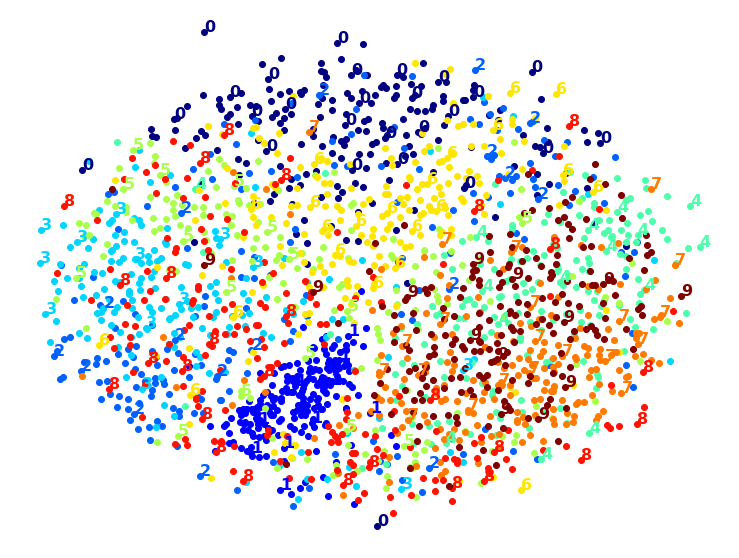

In [130]:
from sklearn.pipeline import Pipeline

pca_mds = Pipeline([
    ("pca", PCA(n_components=0.95, random_state=42)),
    ("mds", MDS(n_components=2, random_state=42)),
])
t0 = time.time()
X_pca_mds_reduced = pca_mds.fit_transform(X[:2000])
t1 = time.time()
print("PCA+MDS took {:.1f}s (on 2,000 MNIST images).".format(t1 - t0))
plot_digits(X_pca_mds_reduced, y[:2000])
plt.show()

Same result, and no speedup: PCA did not help (or hurt).

Let's try LDA:

LDA took 14.2s.


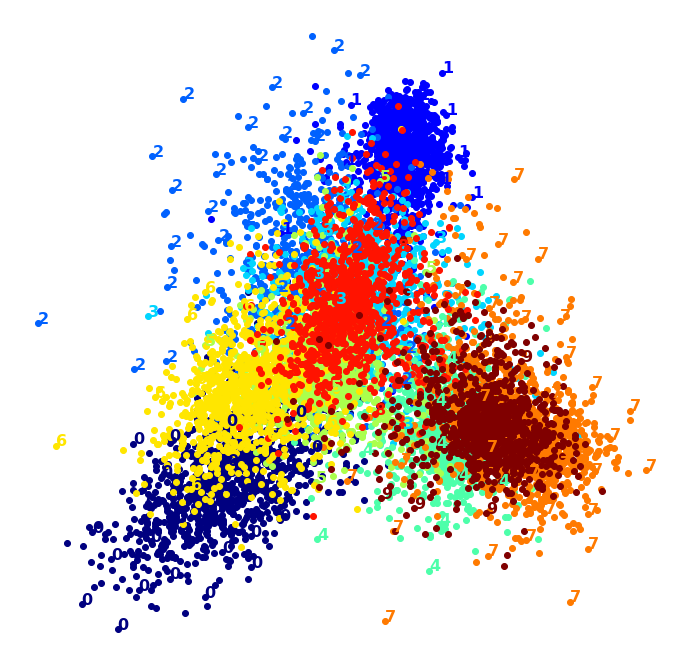

In [131]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

t0 = time.time()
X_lda_reduced = LinearDiscriminantAnalysis(n_components=2).fit_transform(X, y)
t1 = time.time()
print("LDA took {:.1f}s.".format(t1 - t0))
plot_digits(X_lda_reduced, y, figsize=(12,12))
plt.show()

This one is very fast, and it looks nice at first, until you realize that several clusters overlap severely.

Well, it's pretty clear that t-SNE won this little competition, wouldn't you agree? We did not time it, so let's do that now:

/home/dan/miniconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/dan/miniconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


t-SNE took 38.7s.


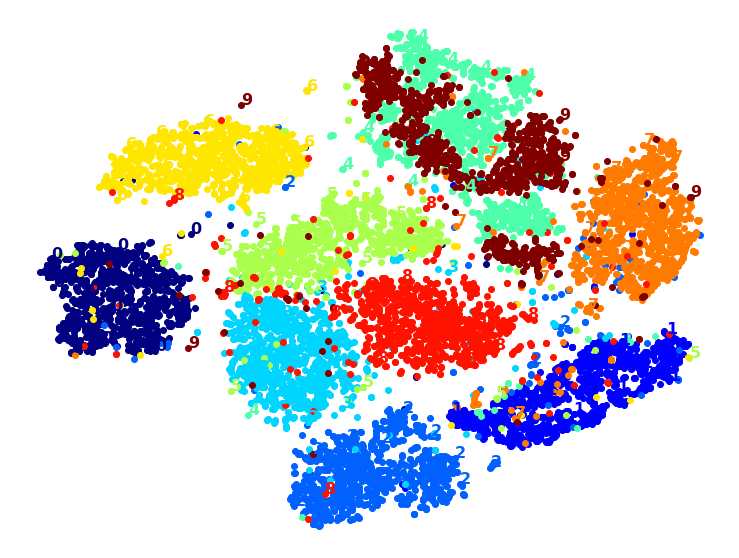

In [132]:
from sklearn.manifold import TSNE

t0 = time.time()
X_tsne_reduced = TSNE(n_components=2, random_state=42).fit_transform(X)
t1 = time.time()
print("t-SNE took {:.1f}s.".format(t1 - t0))
plot_digits(X_tsne_reduced, y)
plt.show()

It's twice slower than LLE, but still much faster than MDS, and the result looks great. Let's see if a bit of PCA can speed it up:

/home/dan/miniconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/dan/miniconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


PCA+t-SNE took 51.8s.


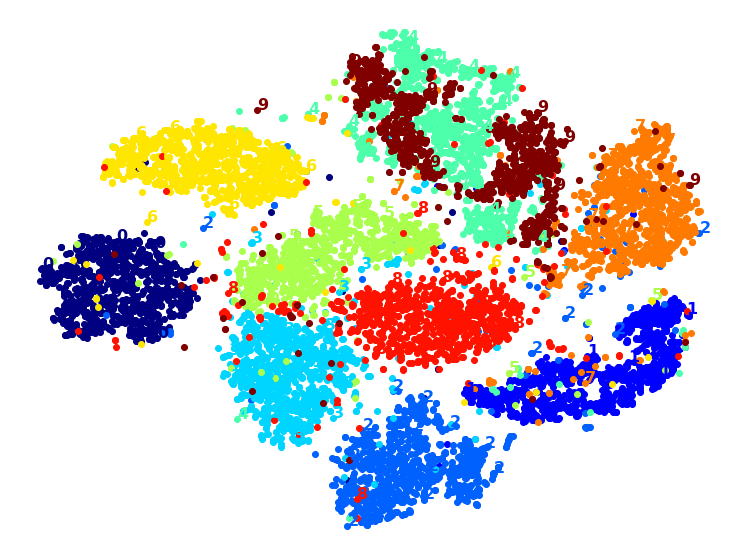

In [133]:
pca_tsne = Pipeline([
    ("pca", PCA(n_components=0.95, random_state=42)),
    ("tsne", TSNE(n_components=2, random_state=42)),
])
t0 = time.time()
X_pca_tsne_reduced = pca_tsne.fit_transform(X)
t1 = time.time()
print("PCA+t-SNE took {:.1f}s.".format(t1 - t0))
plot_digits(X_pca_tsne_reduced, y)
plt.show()